In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
#Use inspector to find column names for each table to help with queries
inspector = inspect(engine)

measurement_columns = inspector.get_columns("measurement")
for column in measurement_columns:
    print(column["name"], column["type"], column["primary_key"])

id INTEGER 1
station TEXT 0
date TEXT 0
prcp FLOAT 0
tobs FLOAT 0


In [10]:
station_columns = inspector.get_columns("station")
for column in station_columns:
    print(column["name"], column["type"], column["primary_key"])

id INTEGER 1
station TEXT 0
name TEXT 0
latitude FLOAT 0
longitude FLOAT 0
elevation FLOAT 0


In [11]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).first()
print(recent_date)

('2017-08-23',)


In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
end_date = dt.datetime.strptime(recent_date[0], '%Y-%m-%d')
# Calculate the date one year from the last date in data set.
start_date = end_date - dt.timedelta(days=365)
print(start_date)

2016-08-23 00:00:00


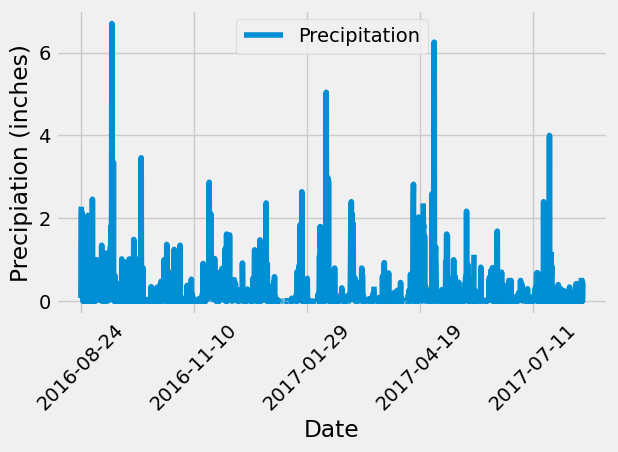

In [13]:
# Perform a query to retrieve the data and precipitation scores
precipitation_values = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= start_date).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_values, columns=['Date', 'Precipitation'])
precipitation_df.set_index('Date', inplace=True)

# Sort the dataframe by date
#sorted by date in original query by ascending order

# Use Pandas Plotting with Matplotlib to plot the data
ax = precipitation_df.plot(rot=45, xlabel='Date', ylabel='Precipiation (inches)')
plt.tight_layout()
plt.show()

In [14]:
#Save Figure
ax.figure.savefig('Annual_Precipitation.png')

In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [16]:
# Design a query to calculate the total number of stations in the dataset
number_of_stations = session.query(Station.station).count()
print(f"The number of stations: {number_of_stations}")

The number of stations: 9


In [17]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
sel = [Measurement.station, func.count(Measurement.id)]

most_active_stations = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()

most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [Measurement.station,
       func.min(Measurement.tobs),
      func.max(Measurement.tobs),
      func.avg(Measurement.tobs)]

active_station_measurements = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).first()

active_station_measurements

('USC00519281', 54.0, 85.0, 71.66378066378067)

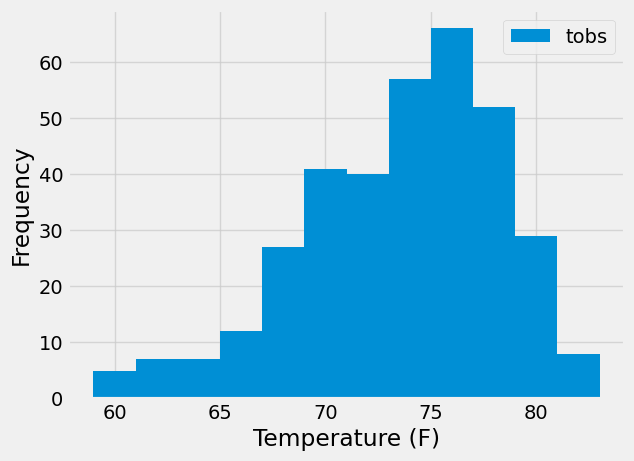

In [26]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperatures = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= start_date).all()

station_df = pd.DataFrame(temperatures, columns=['tobs'])

station_df.plot.hist(bins=12)
plt.grid(alpha=0.75)
plt.ylabel('Frequency')
plt.xlabel('Temperature (F)')
plt.figsize=(10, 5)
plt.legend()
plt.savefig("Temperature_Observations.png", bbox_inches="tight")


In [27]:
plt.show()

# Close Session

In [28]:
# Close Session
session.close()